In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import os, sys, math
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
from Source.Networks.attnet import CausalSelfAttention,  TransformerBlock
from Source.Networks.attnetGMM import attnetGMM
import Source.Util.preprocessing as prep
from torch.nn import functional as F
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader

In [2]:
obs_names = np.array(["p_{T,l1}", "\phi_{l1}", "\eta_{l1}", "\mu_{l1}",
                    "p_{T,l2}", "\phi_{l2}", "\eta_{l2}", "\mu_{l2}",
                  "p_{T,j1}", "\phi_{j1}", "\eta_{j1}", "\mu_{j1}",
                  "p_{T,j2}", "\phi_{j2}", "\eta_{j2}", "\mu_{j2}",
                     "p_{T,j3}", "\phi_{j3}", "\eta_{j3}", "\mu_{j3}"])

# 4-headed attention

In [3]:
runpath = "runs/AutoRegGMM_8194/"

### Load data

In [4]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
device=get_device()
params["device"] =device

In [5]:
data_raw = np.load("../data/Z_3.npy")
data_raw = prep.preformat(data_raw, params)
channels = params["channels"]
data, data_mean, data_std, data_u, data_s, bin_edges, bin_means = prep.preprocess(data_raw, params=params)

### Initialize modified model class

In [6]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=64, n_blocks=1, intermediate_fac=4, n_gauss=85
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


<All keys matched successfully>

### Attention matrix

In [7]:
def getAttentionMatrix(idx):
    b, t = idx.size()
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
    idx = idx.reshape(idx.size(0), idx.size(1), 1)
    tok_emb = model.net.transformer.wte(idx)        
    pos_emb = model.net.transformer.wpe(pos)
    x = model.net.transformer.drop(tok_emb + pos_emb)
    
    B, T, C = x.size()
    print(B, T, C)
    n_head = params["n_head"]
    q, k ,v  = model.net.transformer.h[0].attn.c_attn(x).split(params["intermediate_dim"], dim=2)
    k = k.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    q = q.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    v = v.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    
    
    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    att = att.masked_fill(model.net.transformer.h[0].attn.bias[:,:,:T,:T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    #att = model.net.transformer.h[0].attn.attn_dropout(att) #not used for evaluation
    
    return att.detach().cpu().numpy()

In [8]:
att = getAttentionMatrix(data[:100,:])
print(np.shape(att))

100 17 256
(100, 4, 17, 17)


In [9]:
def plotSingleAttMatrix(att, isample=0, ihead=0):
    att = att[isample, ihead, :, :]
    plt.imshow(att, cmap="Greys")
    plt.colorbar()
    plt.show()

In [23]:
#plotSingleAttMatrix(att, ihead=0)
#plotSingleAttMatrix(att, ihead=1)
#plotSingleAttMatrix(att, ihead=2)
#plotSingleAttMatrix(att, ihead=3)

In [21]:
def plotMultiAttMatrix(attIn, isample=0, fSize=12):
    channels = params["channels"]
    labels = obs_names[channels]
    
    n_features = attIn.shape[2]
    fig, axs = plt.subplots(1, 4, figsize=(16,4))
    for ihead in range(attIn.shape[1]):
        # attention matrix
        att = attIn[isample, ihead, :, :]
        axs[ihead].imshow(att, cmap="Reds")
        
        # mask
        n = len(channels)
        mask = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                mask[i,j] = i<j
        axs[ihead].imshow(mask, cmap="Greys", vmin=0., vmax=1., alpha=.5)
        
        # grid
        minor_locator =FixedLocator(np.arange(len(labels)+1)-.5)
        axs[ihead].xaxis.set_minor_locator(minor_locator)
        axs[ihead].yaxis.set_minor_locator(minor_locator)    
        axs[ihead].grid(which="minor", alpha=.5, lw=.5)
        axs[ihead].tick_params(axis='x', which='minor', bottom=False)
        axs[ihead].tick_params(axis='y', which='minor', left=False)
        
        # labels
        axs[ihead].set_xticks(np.arange(len(labels)))
        axs[ihead].set_xticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=-60)
        axs[ihead].set_yticks(np.arange(len(labels)))
        axs[ihead].set_yticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=0)
    #fig.suptitle(f"Attention matrices for event {isample}")
    fig.savefig(f"Scripts/attmatrix_{isample}.pdf", bbox_inches="tight")
    plt.show()

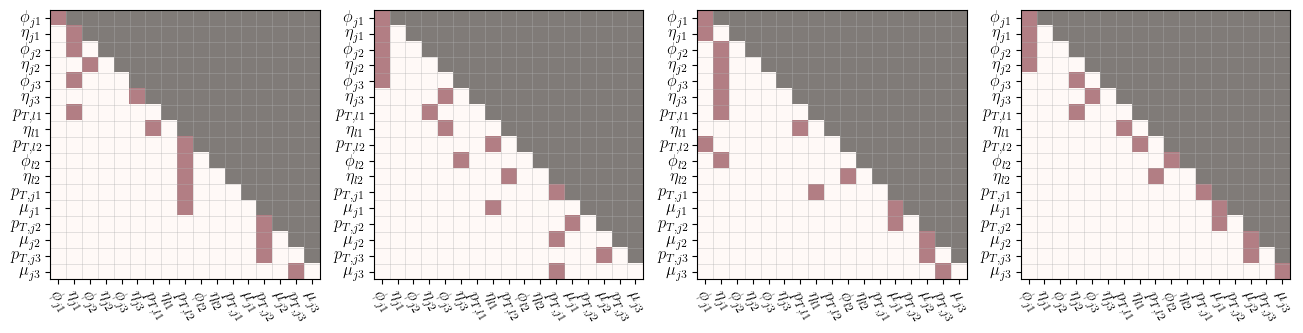

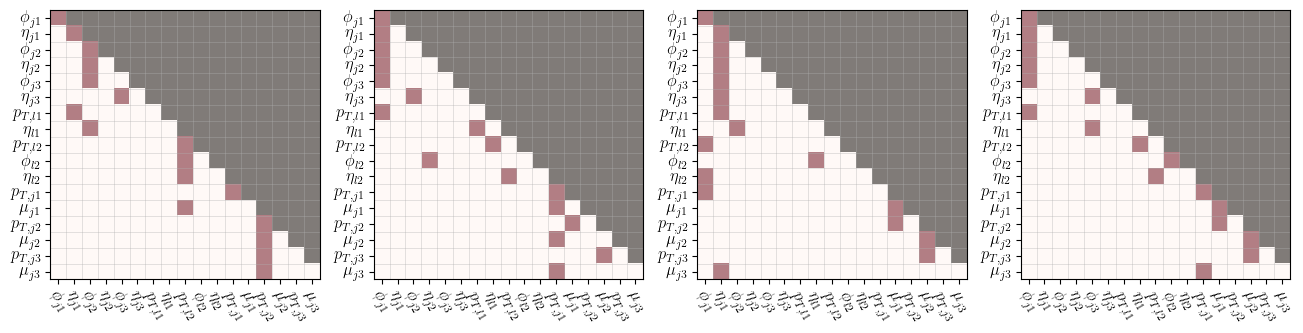

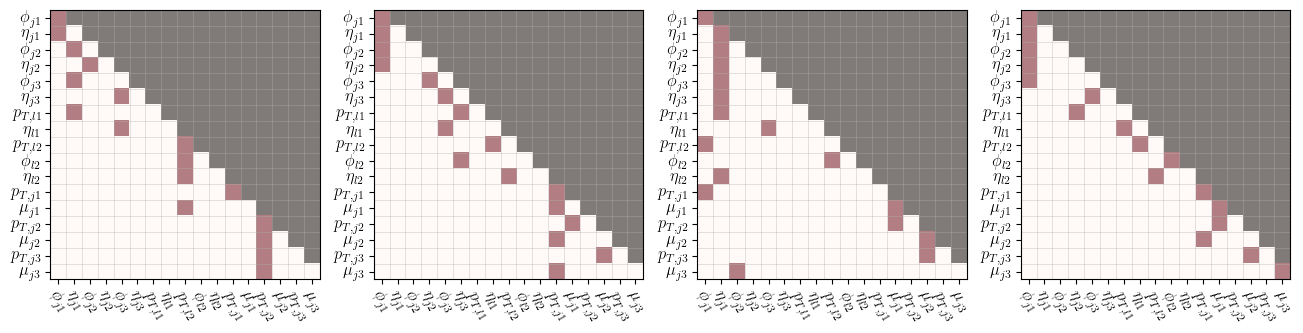

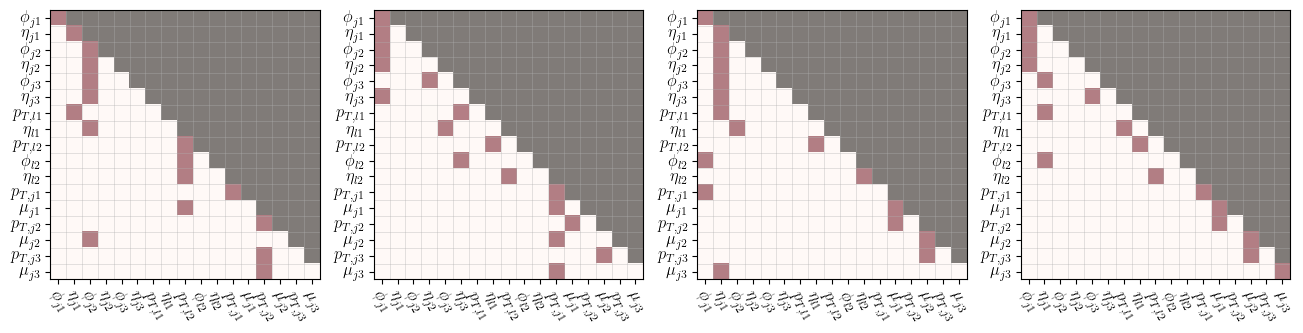

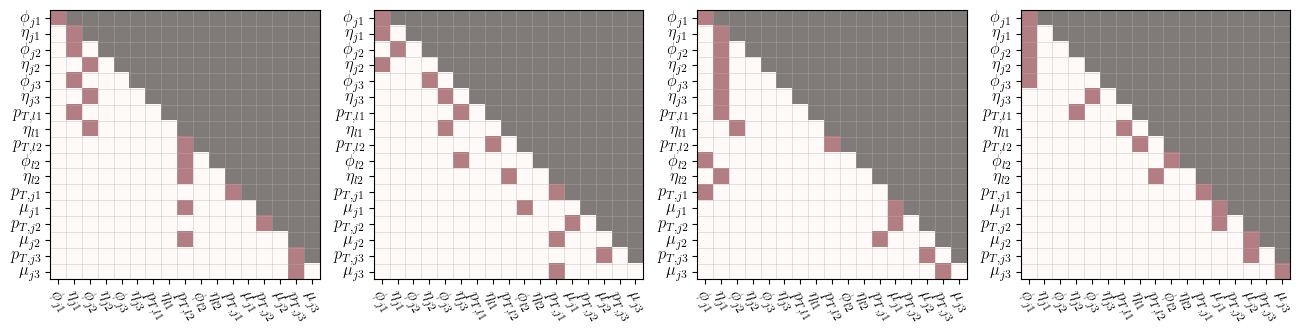

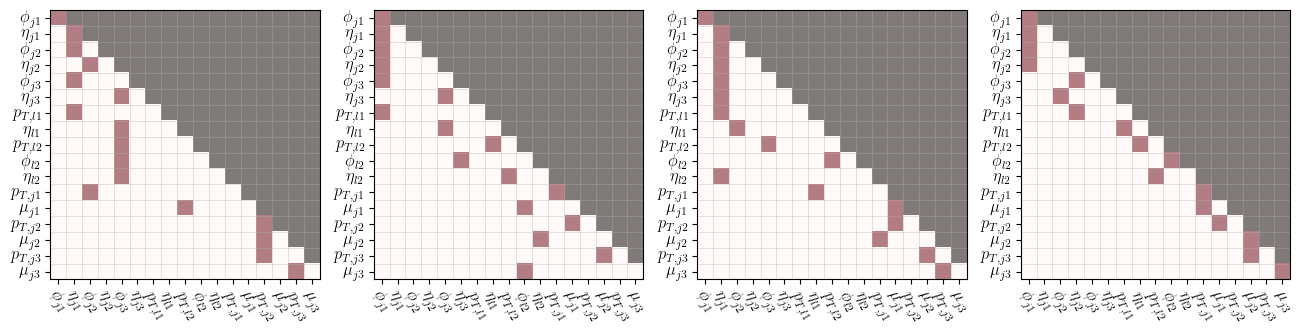

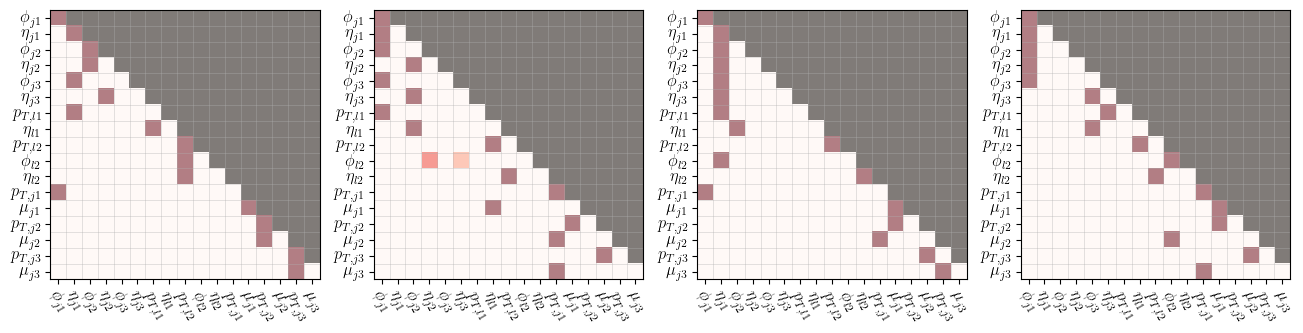

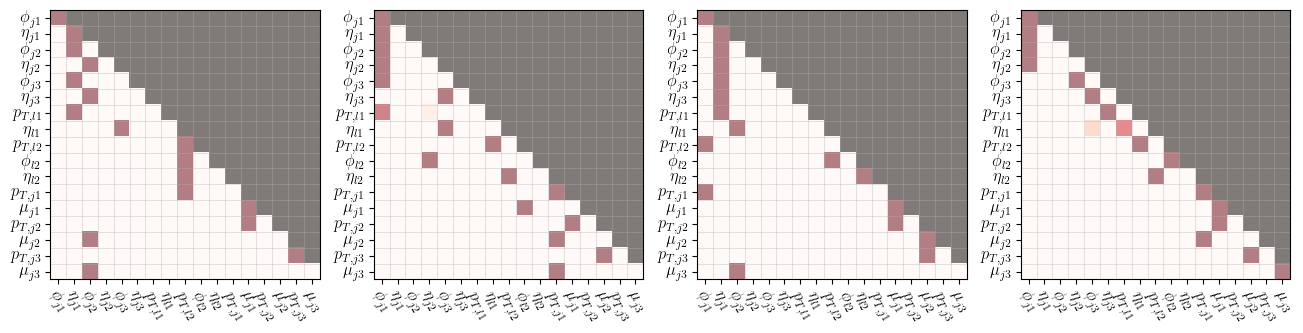

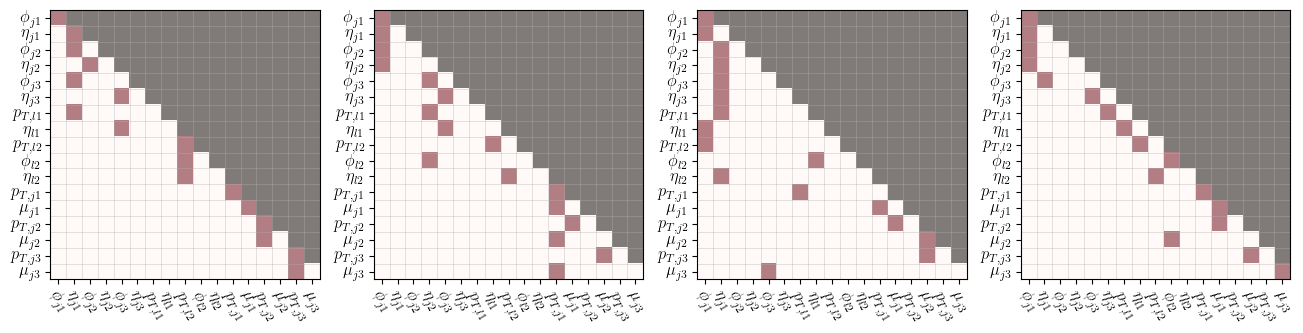

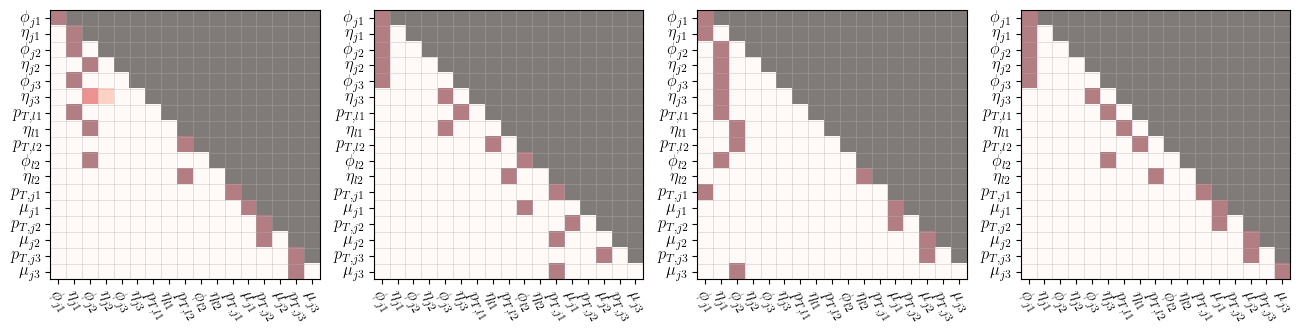

In [22]:
for isample in range(10):
    plotMultiAttMatrix(att, isample=isample)

# 1-headed attention

In [24]:
runpath = "runs/AutoRegGMM_9100/"

### Load data

modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
device=get_device()
params["device"] =device

data_raw = np.load("../data/Z_3.npy")
data_raw = prep.preformat(data_raw, params)
channels = params["channels"]
data, data_mean, data_std, data_u, data_s, bin_edges, bin_means = prep.preprocess(data_raw, params=params)

### Initialize modified model class

model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

### Attention matrix

def getAttentionMatrix(idx):
    b, t = idx.size()
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
    idx = idx.reshape(idx.size(0), idx.size(1), 1)
    tok_emb = model.net.transformer.wte(idx)        
    pos_emb = model.net.transformer.wpe(pos)
    x = model.net.transformer.drop(tok_emb + pos_emb)
    
    B, T, C = x.size()
    print(B, T, C)
    n_head = params["n_head"]
    q, k ,v  = model.net.transformer.h[0].attn.c_attn(x).split(params["intermediate_dim"], dim=2)
    k = k.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    q = q.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    v = v.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    
    
    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    att = att.masked_fill(model.net.transformer.h[0].attn.bias[:,:,:T,:T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    #att = model.net.transformer.h[0].attn.attn_dropout(att) #not used for evaluation
    
    return att.detach().cpu().numpy()

att = getAttentionMatrix(data[:100,:])
print(np.shape(att))


def plotMultiAttMatrix(attIn, isample=0, fSize=12):
    channels = params["channels"]
    labels = obs_names[channels]
    
    n_features = attIn.shape[2]
    fig, axs = plt.subplots(1, 4, figsize=(16,4))
    for ihead in range(attIn.shape[1]):
        # attention matrix
        att = attIn[isample, ihead, :, :]
        axs[ihead].imshow(att, cmap="Reds")
        
        # mask
        n = len(channels)
        mask = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                mask[i,j] = i<j
        axs[ihead].imshow(mask, cmap="Greys", vmin=0., vmax=1., alpha=.5)
        
        # grid
        minor_locator =FixedLocator(np.arange(len(labels)+1)-.5)
        axs[ihead].xaxis.set_minor_locator(minor_locator)
        axs[ihead].yaxis.set_minor_locator(minor_locator)    
        axs[ihead].grid(which="minor", alpha=.5, lw=.5)
        axs[ihead].tick_params(axis='x', which='minor', bottom=False)
        axs[ihead].tick_params(axis='y', which='minor', left=False)
        
        # labels
        axs[ihead].set_xticks(np.arange(len(labels)))
        axs[ihead].set_xticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=-60)
        axs[ihead].set_yticks(np.arange(len(labels)))
        axs[ihead].set_yticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=0)
    #fig.suptitle(f"Attention matrices for event {isample}")
    fig.savefig(f"Scripts/attmatrix_{isample}.pdf", bbox_inches="tight")
    plt.show()

for isample in range(10):
    plotMultiAttMatrix(att, isample=isample)

Model AutoRegGMM hyperparameters: n_head=1, n_per_head=256, n_blocks=1, intermediate_fac=4, n_gauss=85
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1
100 17 256


AttributeError: 'CausalSelfAttention' object has no attribute 'bias'